In [1]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

dev = T.device(T.cuda.current_device() if T.cuda.is_available() else "cpu")
print(dev)

cuda:0


In [2]:
class CNN(nn.Module):
    
    def __init__(self, lr=1e-3):
        super().__init__()
        self.convl1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pooling1 = nn.MaxPool2d(2)
        self.convl2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pooling2 = nn.MaxPool2d(2)
        self.convl3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
        self.pooling3 = nn.MaxPool2d(4)
        inputs = self._get_connected_layer_input()
        self.fcl1 = nn.Linear(inputs, 256)
        #self.drop_out1 = nn.Dropout(p=0.4)
        self.fcl2 = nn.Linear(256, 128)
        #self.drop_out2 = nn.Dropout(p=0.4)
        self.output = nn.Linear(128,1)

        self.lr = lr
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

        self.device = T.device(T.cuda.current_device() if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
        print(f'Neural Net Initialized. Using device : {self.device} !')
        
    def _get_connected_layer_input(self):
        inp = T.zeros(1,3,64,64)
        op = self.convl1(inp)
        op = self.pooling1(op)
        op = self.convl2(op)
        op = self.pooling2(op)
        op = self.convl3(op)
        op = self.pooling3(op)
        return op.view(-1,1).shape[0]

    def forward(self, data):
        op = F.relu(self.convl1(data))
        op = self.pooling1(op)
        op = F.relu(self.convl2(op))
        op = self.pooling2(op)
        op = F.relu(self.convl3(op))
        op = self.pooling3(op)
        op = op.view(op.size()[0],-1)
        op = F.relu(self.fcl1(op))
        #op = self.drop_out1(op)
        op = F.relu(self.fcl2(op))
        #op = self.drop_out2(op)
        op = T.sigmoid((self.output(op)))
        return op

In [3]:
class Data():
    def __init__(self, train_path, test_path, batch_size):
        self.train_path = train_path
        self.test_path = test_path
        self.batch_size = batch_size
        self.class_indx = None

    def get_train_data(self):
        train_data = torchvision.datasets.ImageFolder(root=self.train_path, transform=transforms.Compose([
            transforms.RandomResizedCrop(64),
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([.5, .5, .5], [.2, .2, .2])
        ]))
        self.class_indx = train_data.class_to_idx
        train_data_loader = data.DataLoader(
            train_data, batch_size=self.batch_size, shuffle=True, num_workers=4)
        return train_data_loader

    def get_test_data(self):
        test_data = torchvision.datasets.ImageFolder(root=self.test_path, transform=transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([.5, .5, .5], [.2, .2, .2])
        ]))
        test_data_loader = data.DataLoader(
            test_data, batch_size=self.batch_size, shuffle=True, num_workers=4)
        return test_data_loader


In [4]:
class Agent():
    def __init__(self, train_data, test_data, lr=1e-3, epochs=1):
        self.train_data = train_data
        self.test_data = test_data
        self.lr = lr
        self.epochs = epochs
        self.cnn = CNN(lr)

    def learn(self):
        #self.cnn.train()
        all_loss = []
        all_accuracy = []
        for ep in range(1, self.epochs+1):
            print(f'Epoch {ep}')
            epoch_loss = 0
            epoch_accuracy = 0
            for x_batch, y_batch in self.train_data:
                x_batch, y_batch = x_batch.to(self.cnn.device), y_batch.to(self.cnn.device)
                #print('Data Load Complete')
                self.cnn.optimizer.zero_grad()
                y_pred = self.cnn.forward(x_batch.type(T.float))
                loss = self.cnn.loss(y_pred, y_batch.unsqueeze(1).type(T.float))
                accuracy = self.accuracy(y_pred, y_batch.unsqueeze(1).type(T.float))
                loss.backward()
                self.cnn.optimizer.step()
                epoch_loss += loss.item()
                epoch_accuracy += accuracy.item()
            all_loss.append(epoch_loss/len(self.train_data))
            all_accuracy.append(epoch_accuracy/len(self.train_data))
            test_accuracy, test_loss = self.evaluate()
            print(f'Epoch:{ep} | Train Loss:{epoch_loss/len(self.train_data)} | Train Accuracy:{epoch_accuracy/len(self.train_data)} | Test Loss:{test_loss} | Test Accuracy:{test_accuracy}')
        return all_loss, all_accuracy

    def accuracy(self, y_pred, y_correct):
        y_pred = T.round(y_pred)
        correct_sum = (y_pred == y_correct).sum().float()
        return correct_sum/y_correct.shape[0]
    
    def evaluate(self):
        #self.cnn.eval()
        tot_accuracy = 0
        tot_loss = 0
        for x_test, y_test in self.test_data:
            x, y = x_test.to(self.cnn.device), y_test.to(self.cnn.device)
            y_pred = self.cnn.forward(x)
            tot_accuracy += self.accuracy(y_pred, y.unsqueeze(1))
            tot_loss += self.cnn.loss(y_pred, y.unsqueeze(1).type(T.float))
        return tot_accuracy/len(self.test_data), tot_loss/len(self.test_data)

In [5]:
data_params = {'train_path':'../input/basic-cnn/dataset/training_set','test_path':'../input/basic-cnn/dataset/test_set','batch_size':32}

data_sets = Data(**data_params)

train_data = data_sets.get_train_data()
train_data.pin_memory=True

test_data = data_sets.get_test_data()
test_data.pin_memory=True

In [6]:
data_sets.class_indx

{'cats': 0, 'dogs': 1}

In [7]:
agent_params = {'lr':1e-3,'epochs':50,'train_data':train_data,'test_data':test_data}

agent = Agent(**agent_params)
    
_, _ = agent.learn()

Neural Net Initialized. Using device : cuda:0 !
Epoch 1
Epoch:1 | Train Loss:0.6835840885639191 | Train Accuracy:0.537625 | Test Loss:0.6621233820915222 | Test Accuracy:0.617559552192688
Epoch 2
Epoch:2 | Train Loss:0.6491758539676666 | Train Accuracy:0.6225 | Test Loss:0.630989670753479 | Test Accuracy:0.6453373432159424
Epoch 3
Epoch:3 | Train Loss:0.625649830698967 | Train Accuracy:0.651125 | Test Loss:0.6120046377182007 | Test Accuracy:0.6661706566810608
Epoch 4
Epoch:4 | Train Loss:0.6094188085794449 | Train Accuracy:0.669125 | Test Loss:0.6053673028945923 | Test Accuracy:0.6760913133621216
Epoch 5
Epoch:5 | Train Loss:0.598730629324913 | Train Accuracy:0.679 | Test Loss:0.7753589153289795 | Test Accuracy:0.5709325671195984
Epoch 6
Epoch:6 | Train Loss:0.5958823832273483 | Train Accuracy:0.67875 | Test Loss:0.5803920030593872 | Test Accuracy:0.7003968954086304
Epoch 7
Epoch:7 | Train Loss:0.5939004560708999 | Train Accuracy:0.6815 | Test Loss:0.5906758308410645 | Test Accuracy:0.6

In [8]:
 T.save(agent.cnn.state_dict(), '3conv_78_76')

In [9]:
from PIL import Image
predict_path = '../input/basic-cnn/dataset/single_prediction/'

In [10]:
loader = transforms.Compose([ transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([.5, .5, .5], [.2, .2, .2])])
def image_loader(image_name):
    image = Image.open(image_name)
    plt.imshow(image)
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    #image = image.unsqueeze(0)
    return image

tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward>)

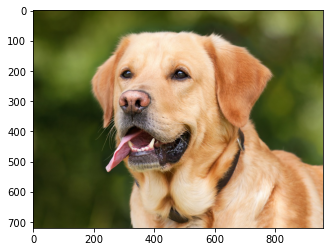

In [11]:
path = predict_path+'cat_or_dog_1.jpg'
img = image_loader(path).to(dev)
T.round(agent.cnn.forward(img.view(1,*img.shape)))

tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward>)

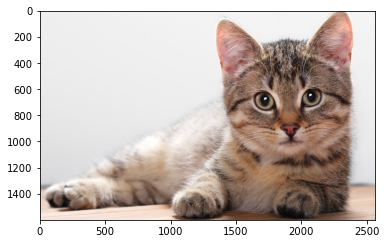

In [12]:
path = predict_path+'cat_or_dog_2.jpg'
img = image_loader(path).to(dev)
T.round(agent.cnn.forward(img.view(1,*img.shape)))